# Link Prediction in NetworKit

## Setup

In [1]:
from networkit import *
%matplotlib inline
import matplotlib.pyplot as plt
import time
from sklearn import *
import numpy as np
import random

No module named 'seaborn'


In [2]:
cd ~/Thesis/NetworKit-Esders

/home/xza/Thesis/NetworKit-Esders


## Choose graph

In [3]:
#testGraph, trainingGraph = linkprediction.readGraph("input/twitter_combined.edgelist", 0.3)
testGraph = readGraph("input/polblogs.graph", Format.METIS)

In [4]:
#for u, v in testGraph.edges():
#    trainingGraph.removeEdge(u, v)
#trainingGraph.numberOfEdges()

In [5]:
#properties.overview(trainingGraph)

## Create training and test set

In [6]:
trainingGraph = linkprediction.TrainingGraphSampler.byPercentage(testGraph, 0.7)
print("Train / Test =", trainingGraph.numberOfEdges(), "/", testGraph.numberOfEdges())

Train / Test = 11700 / 16715


In [7]:
missingLinks = linkprediction.MissingLinksFinder(trainingGraph).findAll(2)
print("2-hop missing links in training graph:", len(missingLinks))

2-hop missing links in training graph: 147764


## Create link predictor instances

In [8]:
katzIndex = linkprediction.KatzIndex(trainingGraph, 5, 0.005)
commonNeighborsIndex = linkprediction.CommonNeighborsIndex(trainingGraph)
jaccardIndex = linkprediction.JaccardIndex(trainingGraph)
preferentialAttachmentIndex = linkprediction.PreferentialAttachmentIndex(trainingGraph)
adamicAdarIndex = linkprediction.AdamicAdarIndex(trainingGraph)
uDegreeIndex = linkprediction.UDegreeIndex(trainingGraph)
vDegreeIndex = linkprediction.VDegreeIndex(trainingGraph)
algebraicDistanceIndex = linkprediction.AlgebraicDistanceIndex(trainingGraph, 5, 10)
algebraicDistanceIndex.preprocess()
neighborhoodDistanceIndex = linkprediction.NeighborhoodDistanceIndex(trainingGraph)
totalNeighborsIndex = linkprediction.TotalNeighborsIndex(trainingGraph)
neighborsMeasureIndex = linkprediction.NeighborsMeasureIndex(trainingGraph)

# Supervised Link Prediction

## Choose link predictors to use as feature-generators

In [9]:
linkPredictors = (commonNeighborsIndex, preferentialAttachmentIndex, jaccardIndex, adamicAdarIndex, uDegreeIndex, vDegreeIndex, algebraicDistanceIndex, neighborhoodDistanceIndex)

## Create training set with negative instances

To train a classifier there has to be a specific training set with positive (link) and negative instances (absent link) which is mostly balanced.
To create this set we randomly pick a given number of positive instances from the trainingGraph. Then we randomly pick the same number of negative instances from the trainingGraph excluding


WARNING: Right now we generate a training set from edges in the test set! Fix this!

In [10]:
positiveInstances = trainingGraph.randomEdges(25000)
negativeInstances = []
while len(negativeInstances) < 25000:
    u = trainingGraph.randomNode()
    v = trainingGraph.randomNode()
    if (u != v and not (testGraph.hasEdge(u, v) or testGraph.hasEdge(u, v)) and not (trainingGraph.hasEdge(u, v) or trainingGraph.hasEdge(u, v)) and trainingGraph.degree(u) > 0 and trainingGraph.degree(v) > 0):
        negativeInstances.append((u, v))
allInstances = positiveInstances + negativeInstances
random.shuffle(allInstances)
allInstances = np.array(allInstances)

nodePairsTrain = allInstances[:40000]
nodePairsTest = allInstances[-10000:]
classesTest = linkprediction.getClasses(nodePairsTest, trainingGraph)
samplesTest = linkprediction.getSamples(nodePairsTest, *linkPredictors)

In [11]:
#allMissing = []
#for i in range(0, trainingGraph.numberOfNodes()):
#    for j in range(i + 1, trainingGraph.numberOfNodes()):
#        if not trainingGraph.hasEdge(i, j) and not trainingGraph.hasEdge(j, i):
#            allMissing.append((i, j))

## Evaluation

In [12]:
roc = linkprediction.ROCMetric(testGraph)
pr = linkprediction.PrecisionRecallMetric(testGraph)

In [13]:
dtc = ensemble.AdaBoostClassifier()
linkprediction.trainClassifier(nodePairsTrain, trainingGraph, dtc, *linkPredictors)

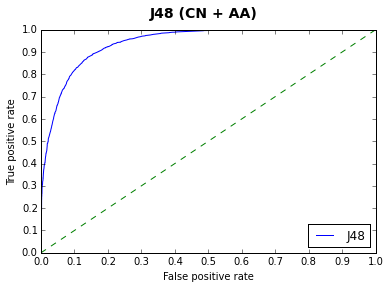

In [14]:
predictionsKNN = dtc.predict_proba(samplesTest)
isEdgePred = [x[1] for x in predictionsKNN]
#sum = 0
#for i in range(0, len(predictionsKNN)):
#    if predictionsKNN[i] == classesTest[i]:
#        sum +=1
#sum
fpr, tpr, thresholds = metrics.roc_curve(classesTest, isEdgePred)
plt.suptitle("J48 (CN + AA)", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
j48, = plt.plot(fpr, tpr, label="J48")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[j48], loc=4)

In [15]:
metrics.roc_auc_score(classesTest, isEdgePred)

0.94232210061454313

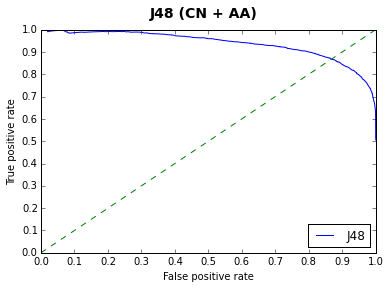

In [16]:
precision, recall, thresholds = metrics.precision_recall_curve(classesTest, isEdgePred)
plt.suptitle("J48 (CN + AA)", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
j48, = plt.plot(recall, precision, label="J48")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[j48], loc=4)

In [17]:
pr.getAreaUnderCurve((recall, precision))

0.9378305480577818

In [18]:
startTime = time.time()
predictions = commonNeighborsIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.09492278099060059 seconds


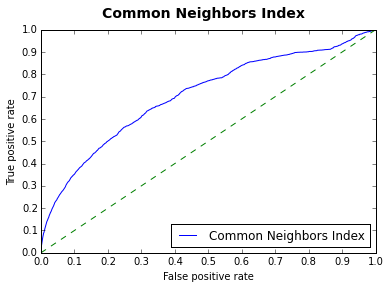

In [19]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Common Neighbors Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Common Neighbors Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [20]:
roc.getAreaUnderCurve()

0.705176255796115

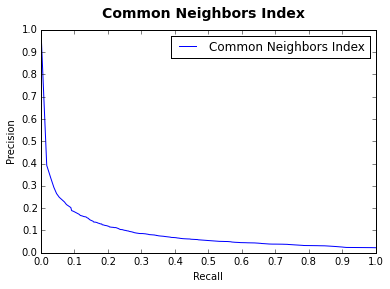

In [21]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Common Neighbors Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Common Neighbors Index")
plt.legend(handles=[curve])

In [22]:
pr.getAreaUnderCurve()

0.09042214080704093

In [23]:
startTime = time.time()
predictions = jaccardIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.2328495979309082 seconds


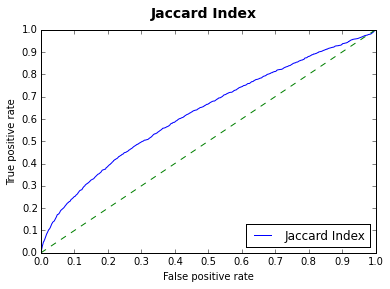

In [24]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Jaccard Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Jaccard Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [25]:
roc.getAreaUnderCurve()

0.630068082953793

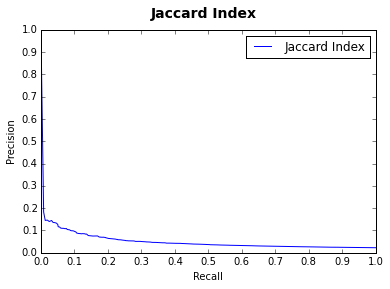

In [26]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Jaccard Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Jaccard Index")
plt.legend(handles=[curve])

In [27]:
pr.getAreaUnderCurve()

0.052356271945287434

In [28]:
startTime = time.time()
predictions = preferentialAttachmentIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.10063624382019043 seconds


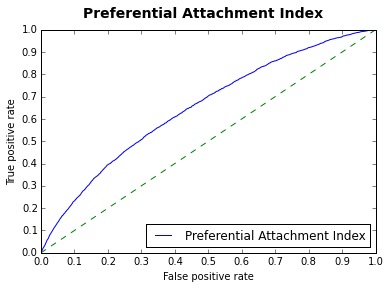

In [29]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Preferential Attachment Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Preferential Attachment Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [30]:
roc.getAreaUnderCurve()

0.6502415043152258

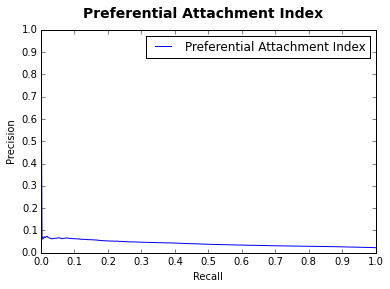

In [31]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Preferential Attachment Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Preferential Attachment Index")
plt.legend(handles=[curve])

In [32]:
pr.getAreaUnderCurve()

0.04288780455623836

In [33]:
startTime = time.time()
predictions = adamicAdarIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.16505193710327148 seconds


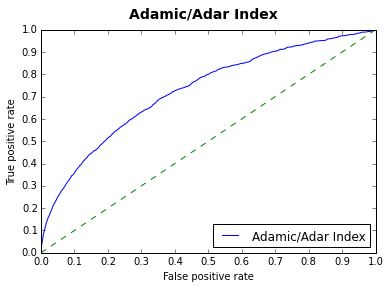

In [34]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Adamic/Adar Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Adamic/Adar Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [35]:
roc.getAreaUnderCurve()

0.7258157050512399

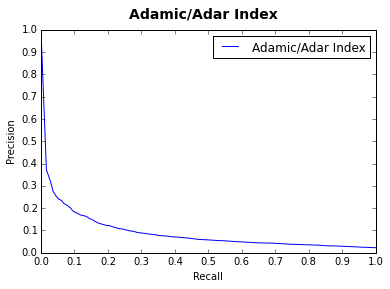

In [36]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Adamic/Adar Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Adamic/Adar Index")
plt.legend(handles=[curve])

In [37]:
pr.getAreaUnderCurve()

0.09139971494264819

In [38]:
startTime = time.time()
predictions = uDegreeIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.05589914321899414 seconds


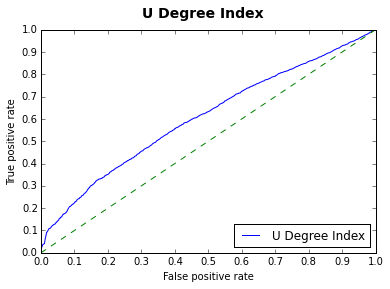

In [39]:
X, Y = roc.getCurve(predictions)
plt.suptitle("U Degree Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="U Degree Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [40]:
roc.getAreaUnderCurve()

0.6053810870919458

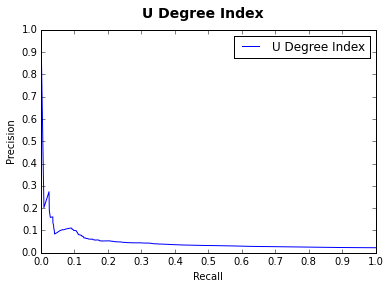

In [41]:
X, Y = pr.getCurve(predictions)
plt.suptitle("U Degree Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="U Degree Index")
plt.legend(handles=[curve])

In [42]:
pr.getAreaUnderCurve()

0.04971240866263375

In [43]:
startTime = time.time()
predictions = vDegreeIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.11514902114868164 seconds


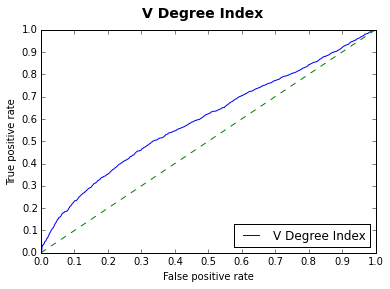

In [44]:
X, Y = roc.getCurve(predictions)
plt.suptitle("V Degree Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="V Degree Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [45]:
roc.getAreaUnderCurve()

0.5979887145559605

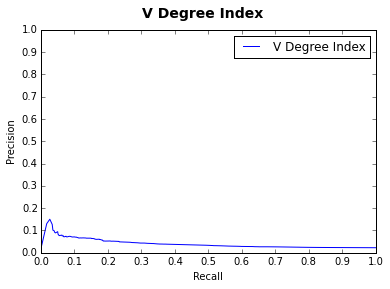

In [46]:
X, Y = pr.getCurve(predictions)
plt.suptitle("V Degree Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="V Degree Index")
plt.legend(handles=[curve])

In [47]:
pr.getAreaUnderCurve()

0.04122737334352187

In [48]:
startTime = time.time()
algebraicDistanceIndex.preprocess()
predictions = algebraicDistanceIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.0700843334197998 seconds


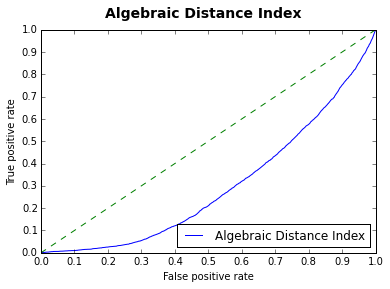

In [49]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Algebraic Distance Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Algebraic Distance Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [50]:
roc.getAreaUnderCurve()

0.29765117653036166

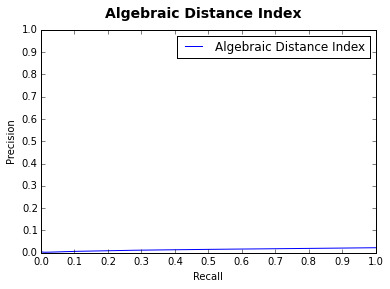

In [51]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Algebraic Distance Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Algebraic Distance Index")
plt.legend(handles=[curve])

In [52]:
pr.getAreaUnderCurve()

0.01481832768175027

In [53]:
startTime = time.time()
predictions = neighborhoodDistanceIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.16079068183898926 seconds


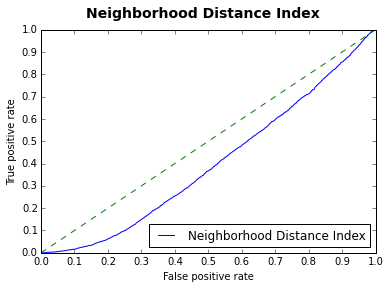

In [54]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Neighborhood Distance Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Neighborhood Distance Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [55]:
roc.getAreaUnderCurve()

0.39936466197902903

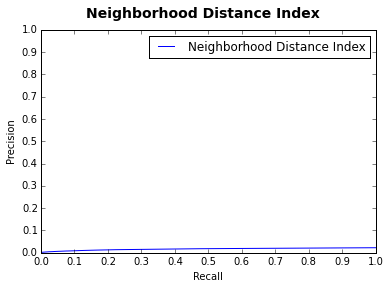

In [56]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Neighborhood Distance Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Neighborhood Distance Index")
plt.legend(handles=[curve])

In [57]:
pr.getAreaUnderCurve()

0.017022748013083015

In [58]:
#node = trainingGraph.randomNode()
#nodes = trainingGraph.neighbors(node)
#subGraph = graph.Subgraph().fromNodes(trainingGraph, nodes)

In [59]:
#LIST_LENGTH = len(nodes) - 1
#a = []
#color = {}
#while len(a) < LIST_LENGTH:
#    a.append(500)
#for e in nodes:
#    color[e] = len(nodes)
#a.append(2000)
#len(color)
#color[list(color)[-1]] = len(nodes) / 2
#color[list(color)[-2]] = len(nodes) / 3

In [60]:
#viztasks.drawGraph(subGraph, (7,7), False, a, None, color)

In [61]:
startTime = time.time()
predictions = katzIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

3.2631421089172363 seconds


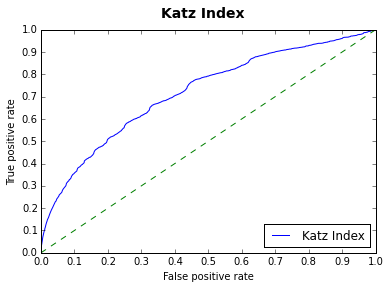

In [62]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Katz Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Katz Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [63]:
roc.getAreaUnderCurve()

0.717638302496152

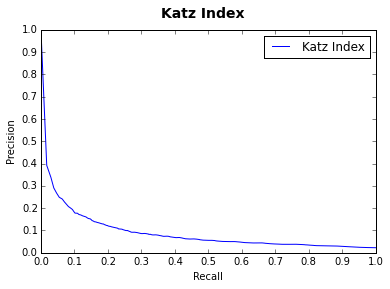

In [64]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Katz Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Katz Index")
plt.legend(handles=[curve])

In [65]:
pr.getAreaUnderCurve()

0.09162935191529048

In [66]:
startTime = time.time()
predictions = totalNeighborsIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

0.20249605178833008 seconds


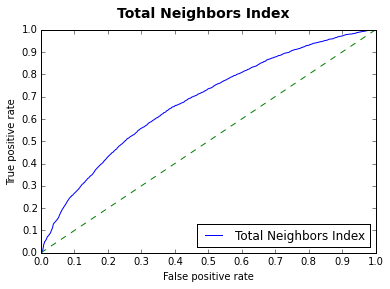

In [67]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Total Neighbors Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Total Neighbors Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [68]:
roc.getAreaUnderCurve()

0.676064771580356

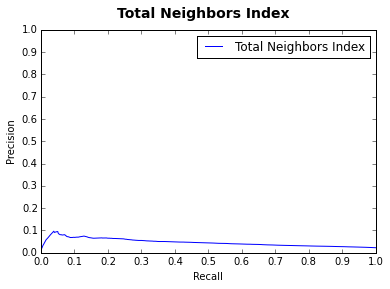

In [69]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Total Neighbors Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Total Neighbors Index")
plt.legend(handles=[curve])

In [70]:
pr.getAreaUnderCurve()

0.046883040151465896

In [71]:
startTime = time.time()
predictions = neighborsMeasureIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - startTime))

3.217616558074951 seconds


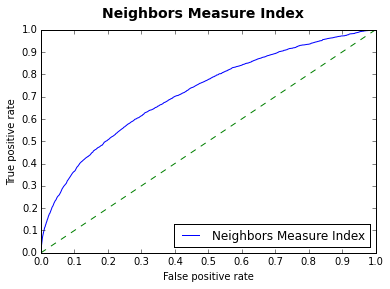

In [72]:
X, Y = roc.getCurve(predictions)
plt.suptitle("Neighbors Measure Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Neighbors Measure Index")
plt.plot([0, 1], [0, 1], ls='--')
plt.legend(handles=[curve], loc=4)

In [73]:
roc.getAreaUnderCurve()

0.7179021962211527

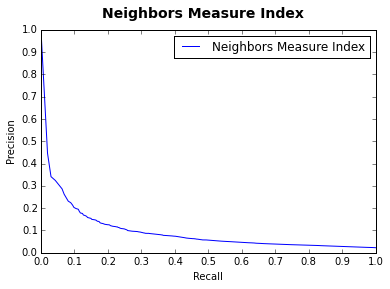

In [74]:
X, Y = pr.getCurve(predictions)
plt.suptitle("Neighbors Measure Index", fontsize=14, fontweight="bold")
plt.xticks([z / 10 for z in range(11)])
plt.yticks([z / 10 for z in range(11)])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
curve, = plt.plot(X, Y, label="Neighbors Measure Index")
plt.legend(handles=[curve])

In [75]:
pr.getAreaUnderCurve()

0.09717711552442124